In [1]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from skimage.transform import iradon

import seaborn as sns

%matplotlib inline

# Drae a set of emitters and detectors

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

def draw_des(ds, es, width, height):

    ## Cairo STUFF

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)
        
    return surface

def draw_des_surf(surface, ds, es, width, height):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

/home/jonathan/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Read in the dataset
This consists of 500 sets of readings taken in different positions

In [2]:
r8 = pd.read_csv('posinf8_500_readings.csv') # The readings taken experimentally

# Specify the emitter and detector locations. These have to match the orientation and order of the experiment. Hence the angle offset and -ve direction vs other examples

In [3]:
es = []
ds = []

off = 7*math.pi/8 # Found iteratively. Can refine

for i in range(8):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':off - math.pi*(i+0.5)/4, #2*math.pi*i/8,
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':off - math.pi*(i)/4, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)

# Take 500 simulated sets of readings with the same (translated) positions as the experiment. These should correlate with the experimental values.

In [4]:
paths = []
pos = r8[['X', 'Y']].values
for p in pos:
    xp, yp = (p[0]-2.5)/2.5, (p[1]-2.5)/2.5
    s, i, x, y = test_image(500, 500, 70, xp, yp)
    path = get_paths(i, ds, es, 500, 500)
    paths.append(path)
r8sim = pd.DataFrame(paths)

a = r8sim[[i for i in range(64)]].values
b = r8[[str(i+8) for i in range(64)]].values

## Finding the correlation:
We must get the difference between the base readings and the others. b2 becomes our R vector. we want S to correlate. Using S = log(a+1) to log transform the simulated values.

In [5]:
base = np.mean(r8[[str(i) for i in range(8)]]).values
b2 = []
for rs in b:
    r2s = []
    for i in range(64):
        r2s.append(base[(i)%8] - rs[i])
    b2.append(r2s)
corr = np.mean([np.corrcoef(b2[x],np.log(a[x]+1))[0][1] for x in range(50)])
corr

0.41517613844317125

## Plotting real vs sim, we see they sort of line up! 

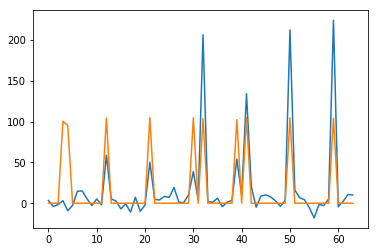

In [6]:
plt.plot(b2[4])
plt.plot(np.log(a[4]+1)*10)

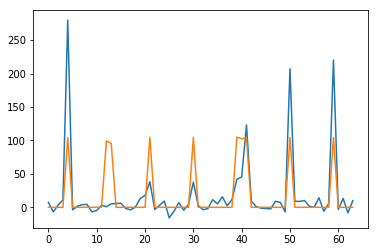

In [7]:
plt.plot(b2[9])
plt.plot(np.log(a[9]+1)*10)

## To improve this and account for LED non-linearities etc, we get a scaling matrix to better map sim -> real

In [8]:
a2 = np.asarray([np.log(a[i]+1)+7 for i in range(len(a))])
# print(a2.shape)
sfs = np.asarray(b2)/a2
# print(sfs.shape)
sf = [] # scaling factors
for i in range(64):
    sf.append(np.mean([sfs[n][i] for n in range(500)]))

sf now contains a set of scaling factors. Multiplying a2 by sf gives a3 (s3 in paper notes), which is now highly correlated to b3 (R)

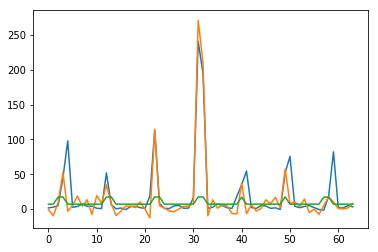

In [9]:
a3 = (a2*sf) # transformed, scaled simulated readings
b3 = np.asarray(b2) # experimental readings (ref to base)

# Plotting an example:
plt.plot(a3[2]) # Add legend
plt.plot(b3[2])
plt.plot((a2)[2]) # The unscaled sim values

In [10]:
# The correlation:
np.mean([np.corrcoef(b3[x],a3[x])[0][1] for x in range(500)])

0.8356664226161561

# Now for the fun bit

Building a model with the transformed, simulated readings. We'll just try to predict X location for simplicity and plotting.

In [11]:
X = a3
y = r8['X']

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

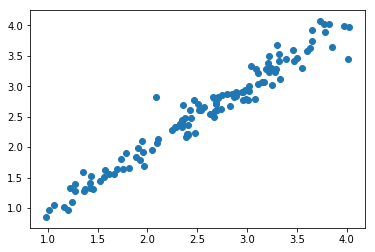

In [12]:
plt.scatter(y_test, mlpc.predict(X_test))

In [13]:
math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2)) # RMSE

0.16352047304605002

Now one with only 100 actual readings

In [23]:
X_train = b3[:100]
y_train = r8['X'].values[:100]

X_test = b3[-100:]
y_test = r8['X'].values[-100:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)

math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2)) # RMSE

0.9075532879707705

In [24]:
# (SHould use CV) <<<<<<<<<<<<<<

Using the same test set, does the model improve with more real readings?

In [25]:
X_train = b3[:200]
y_train = r8['X'].values[:200]

X_test = b3[-100:]
y_test = r8['X'].values[-100:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)
math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2)) # RMSE

0.8177985037076494

What if we train on purely simulated data?

In [26]:
X_train = a3[:200]
y_train = r8['X'].values[:200]

X_test = b3[-100:]
y_test = r8['X'].values[-100:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=200)
mlpc.fit(X_train, y_train)
math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2)) # RMSE

232212219348080.5

Oops!

### Training with some simulated data and some real data

In [27]:
a4 = []
for a in a3:
    aa2 = []
    for s in a:
        if s < 25:
            aa2.append(s/2 - 20)
        else:
            aa2.append(s)
    a4.append(aa2)
a4 = np.asarray(a4)

an = 300
X_train = b3[:100]
X_train = np.concatenate((X_train, a4[:an]), axis=0)
y_train = np.concatenate((r8['X'].values[:100], r8['X'].values[:an]), axis=0)

X_test = b3[-100:]
y_test = r8['X'].values[-100:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)
math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2)) # RMSE

0.8503476539721443

## Making new simulated data and training with that

In [28]:
pos2 = []
xs = []
for i in range(1000):
    x = random.random()*2 - 1
    y = random.random()*2 - 1
    while ((x-2.5)**2 + (y-2.5)**2)>2.5: # Check within safe radius
        x = random.random()*5
        y = random.random()*5
    pos2.append([x, y])
    xs.append(x)

In [29]:
paths = []
for p in pos2:
    xp, yp = (p[0]-2.5)/2.5, (p[1]-2.5)/2.5
    s, i, x, y = test_image(500, 500, 70, xp, yp)
    path = get_paths(i, ds, es, 500, 500)
    paths.append(path)
r8sim = pd.DataFrame(paths)

c = r8sim[[i for i in range(64)]].values
c2 = np.asarray([np.log(c[i]+1)+7 for i in range(len(c))])
c3 = (c2*sf)

In [30]:
c4 = []
for c in c3:
    aa2 = []
    for s in c:
        if s < 35:
            aa2.append(s/2-20)
        else:
            aa2.append(s)
    c4.append(aa2)
c4 = np.asarray(c4)

an = 1000
X_train = b3[:400]
X_train = np.concatenate((X_train, c4[:an]), axis=0)
y_train = np.concatenate((r8['X'].values[:400], xs[:an]), axis=0)

X_test = b3[-100:]
y_test = r8['X'].values[-100:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rmse = []

for i in range(50):
    mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    mlpc.fit(X_train, y_train)
    rmse.append(math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2))) # RMSE
print(np.mean(rmse))

0.5947864398446115


And without the simulated data:

In [31]:
X_train = b3[:400]
y_train = r8['X'].values[:400]

X_test = b3[-100:]
y_test = r8['X'].values[-100:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rmse = []

for i in range(50):
    mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    mlpc.fit(X_train, y_train)
    rmse.append(math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2))) # RMSE
print(np.mean(rmse))

0.7037236357364727


The model without the added simulation data does worse! Success!

# Plotting the improvement in scores

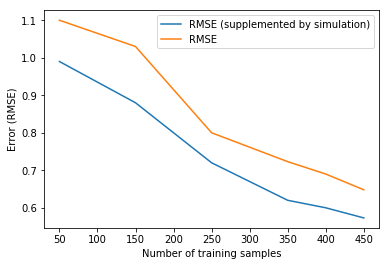

In [33]:
ns = [10, 50, 150, 250, 350, 400, 450]
scores_sim = [1.38, 0.99, 0.88, 0.72, 0.62, 0.60, 0.573]
scores_base = [1.22, 1.1, 1.03, 0.80, 0.723, 0.69, 0.648]
plt.plot(ns[1:], scores_sim[1:], label='RMSE (supplemented by simulation)') # With simulated data
plt.plot(ns[1:], scores_base[1:], label='RMSE') # Without sim
plt.xlabel('Number of training samples')
plt.ylabel('Error (RMSE)')
plt.legend()
plt.savefig('RMSE vs n samples, with 1000 simulated readings.png')

In [46]:
ns = range(50, 451, 100)
scores_sim = []
ss = []
scores_base = []
sb = []

for nt in ns:
    print(nt)
    c4 = []
    for c in c3:
        aa2 = []
        for s in c:
            if s < 35:
                aa2.append(s/2-20)
            else:
                aa2.append(s)
        c4.append(aa2)
    c4 = np.asarray(c4)

    an = 1000
    X_train = b3[:nt]
    X_train = np.concatenate((X_train, c4[:an]), axis=0)
    y_train = np.concatenate((r8['X'].values[:nt], xs[:an]), axis=0)

    X_test = b3[-50:]
    y_test = r8['X'].values[-50:]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    rmse = []

    for i in range(50):
        mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=600)
        mlpc.fit(X_train, y_train)
        rmse.append(math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2))) # RMSE
    scores_sim.append(np.mean(rmse))
    ss.append(np.median(rmse))
    
    
    X_train = b3[:nt]
    y_train = r8['X'].values[:nt]

    X_test = b3[-50:]
    y_test = r8['X'].values[-50:]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    rmse = []

    for i in range(50):
        mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=600)
        mlpc.fit(X_train, y_train)
        rmse.append(math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2))) # RMSE
    scores_base.append(np.mean(rmse))
    sb.append(np.median(rmse))

50
150
250
350
450


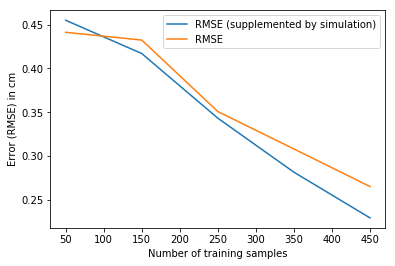

In [47]:
plt.plot(ns, np.asarray(scores_sim)/2.5, label='RMSE (supplemented by simulation)') # With simulated data
plt.plot(ns, np.asarray(scores_base)/2.5, label='RMSE') # Without sim
plt.xlabel('Number of training samples')
plt.ylabel('Error (RMSE) in cm')
plt.legend()
plt.savefig('RMSE vs n samples 9.png')